# <span style="color:blue">Desafío 6- Prediciendo las ventas de una tienda</span>

## <span style="color:orange">Importación de librerías - Cargar y visualizar la data</span>

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Paso 1: Importar y visualizar datos
# Cargar datos del archivo proporcionado
file_path = r'C:\Users\atapi\Documents\DATA SCIENCE\Modulo 5-ML\aprendizaje no supervisado V\desafio\Apoyo Desafío - Prediciendo las ventas de una tienda\Sales_Data.xlsx'
data = pd.read_excel(file_path)

# Visualizar las primeras filas para entender el formato del dataset para inspeccionar el formato del conjunto de datos.
print("Primeras filas del dataset:\n")
data.head()


Primeras filas del dataset:



,Order Date,Sales
0,2015-01-01,14205.707
1,2015-02-01,4519.892
2,2015-03-01,55205.797
3,2015-04-01,27906.855
4,2015-05-01,23644.303


In [67]:
# Mostrar nombres de columnas para identificar posibles errores en los encabezados.
print("Nombres de las columnas:")
print(data.columns)

Nombres de las columnas:
Index(['Order Date', 'Sales'], dtype='object')


In [68]:
'''Asegurar que la columna de fecha sea tipo datetime y establecerla como índice:
- "Order Date" se convierte al tipo datetime para manejar correctamente las fechas.
- Se ordenan los datos cronológicamente con "sort_values()" utilizando la columna "Order Date".
- Se establece la columna "Order Date" como índice del DataFrame para facilitar el análisis de series de tiempo.'''

#Asegurar que la columna de fecha sea tipo datetime y establecerla como índice
data['Order Date'] = pd.to_datetime(data['Order Date'])

# Ordenar los datos por la columna 'Order Date'
data = data.sort_values(by='Order Date')

# Establecer 'Order Date' como índice
data.set_index('Order Date', inplace=True)


# Obtener información de la data con las modificaciones
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48 entries, 2015-01-01 to 2018-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Sales   48 non-null     float64
dtypes: float64(1)
memory usage: 768.0 bytes


In [69]:
# Se verifica si hay valores nulos en el conjunto de datos. Esto asegura que no haya registros incompletos.
print(data.isnull().sum())


Sales    0
dtype: int64


## <span style="color:orange">Descomposición de la serie de tiempo</span>

**En el paso 2 realizaremos la descomposición de la Serie de Tiempo.**

- **El objetivo** es visualizar la evolución de las ventas a lo largo del tiempo, además de identificar patrones como tendencias, estacionalidad, o posibles anomalías que pueden influir en el análisis posterior.

- **El análisis Exploratorio Visual**, es una práctica fundamental en el análisis de series de tiempo para obtener una comprensión inicial de los datos. Este análisis inicial permite detectar patrones generales:

    - **Tendencia:** Incremento o disminución global en las ventas.
    - **Estacionalidad:** Repetición periódica de patrones.
    - **Ruido:** Fluctuaciones aleatorias sin patrón aparente.

- **Preparación para la Descomposición:** La descomposición de la serie de tiempo requiere identificar los patrones antes mencionados. Este gráfico inicial es un paso preliminar para validar visualmente si los datos parecen adecuados para descomposición.

- **En el gráfico se puede observar:**
    - Cambios en el comportamiento de las ventas.
    - Estacionalidad o periodicidad en las ventas.
    - Posibles picos, caídas, o anomalías que podrían requerir limpieza de datos.

Además el gráfico ofrece una representación visual clara de las ventas mensuales, facilitando la identificación de patrones generales antes de aplicar los modelos.

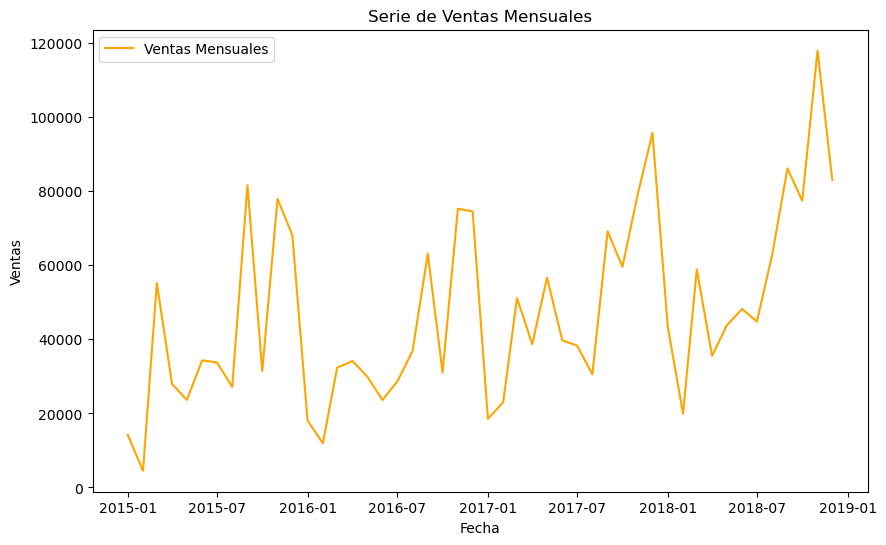

In [71]:
# Paso 2: Descomposición de la serie de tiempo

# Configurar el tamaño de la figura para mejor visualización
plt.figure(figsize=(10, 6))

# Graficar la serie temporal con las ventas mensuales
plt.plot(data, label='Ventas Mensuales', color='orange')

# Agregar un título descriptivo al gráfico
plt.title('Serie de Ventas Mensuales')

# Etiquetas de los ejes
plt.xlabel('Fecha')  # Etiqueta para el eje X (fechas)
plt.ylabel('Ventas')  # Etiqueta para el eje Y (ventas)

# Mostrar la leyenda para identificar la línea en el gráfico
plt.legend()

# Mostrar el gráfico
plt.show()



**<span style="color:olive">Descripción del Gráfico</span>**

- El gráfico representa la serie temporal de las ventas mensuales de una tienda, donde:

    - Eje X (Fecha): Muestra el rango de tiempo desde enero de 2015 hasta principios de 2019.
    - Eje Y (Ventas): Representa las cifras de ventas mensuales en unidades monetarias.

**Observaciones**

- **Tendencia general:** Se puede observar un incremento gradual en las ventas a lo largo del tiempo, especialmente en el período posterior a 2017.
- **Variabilidad:** Las ventas presentan fluctuaciones significativas, con picos pronunciados en ciertos meses y caídas notables en otros.
- **Posible Estacionalidad:** Algunas fluctuaciones parecen repetirse, lo cual podría indicar un comportamiento estacional.

---
---
#### <span style="color:purple">Descomposición de la Serie de Tiempo</span>

**Explicación del código**

- Se utiliza la función **seasonal_decompose()** para descomponer la serie de ventas en tres componentes principales:
    - *Tendencia* 
    - *Estacionalidad* 
    - *Residuo*

      
- **Se generan gráficos individuales para:**

    - La serie original (ventas mensuales).
    - La tendencia (comportamiento a largo plazo).
    - La estacionalidad (patrones periódicos).
    - El residuo (ruido).


- **Importancia de descomponer una serie:**

    - Facilita la identificación de patrones en los datos.
    - Ayuda a entender si los cambios observados se deben a la tendencia, la estacionalidad o al ruido.
    - Es un paso muy importante antes de aplicar modelos como ARIMA, ya que estos requieren que la serie sea estacionaria.
    - Podemos analizar cómo los factores individuales afectan las ventas mensuales, lo que permite construir modelos predictivos más precisos.

- **Gráficos generados**
    - *Serie Original:* Muestra las ventas en su forma completa.
    - *Tendencia:* Una curva suave que indica el comportamiento a largo plazo (incremento o decremento).
    - *Estacionalidad:* Patrones repetitivos en las ventas.
    - *Residuo:* Las diferencias entre los datos originales y los componentes anteriores, lo que puede ser ruido o anomalías.

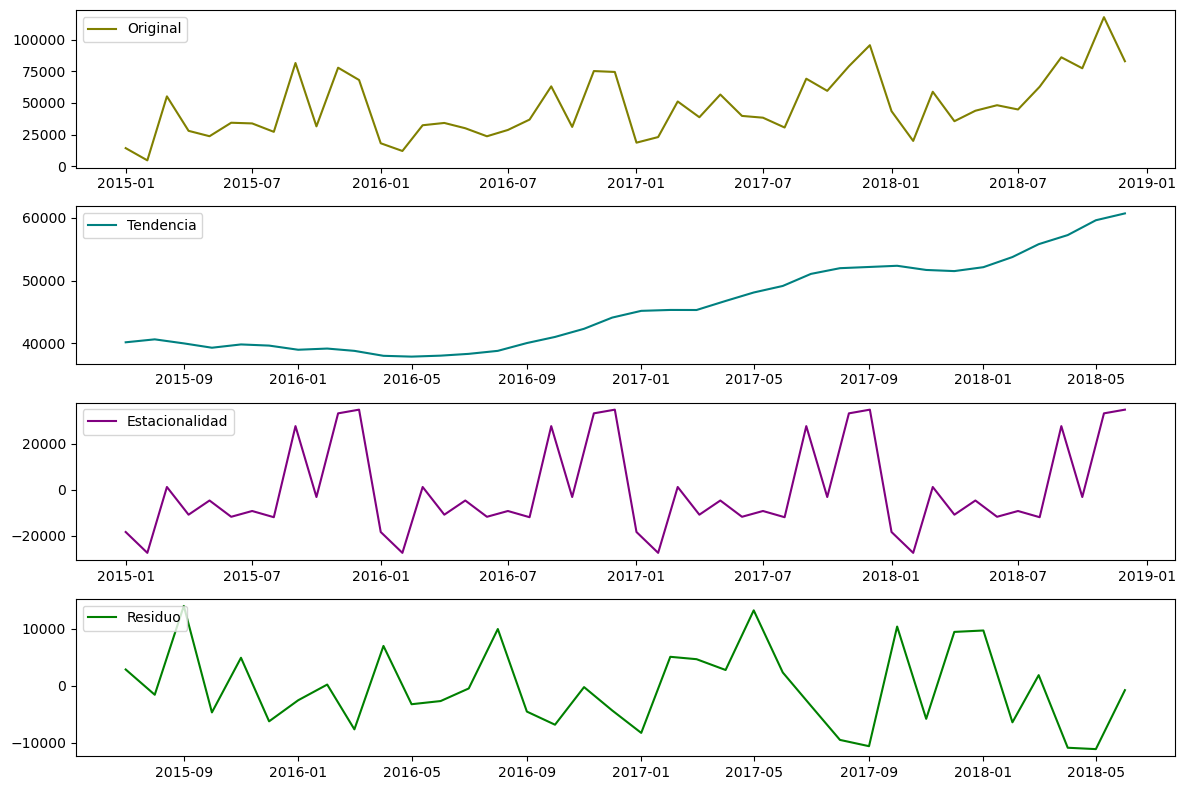

In [73]:
# Descomposición de la serie de tiempo en componentes
# Utilizando el modelo aditivo para separar la serie en:
# - Tendencia: Comportamiento general (aumento o disminución) de las ventas a lo largo del tiempo.
# - Estacionalidad: Fluctuaciones periódicas regulares en las ventas.
# - Residuo: Variaciones aleatorias no explicadas por la tendencia ni la estacionalidad.
result = seasonal_decompose(data, model='additive')

# Extraer cada componente de la descomposición
trend = result.trend      # Tendencia general de la serie
seasonal = result.seasonal  # Componente estacional - patrones repetitivos
residual = result.resid    # Componente residual 

# Graficar los componentes de la descomposición
plt.figure(figsize=(12, 8))

# Gráfico 1: Serie original
plt.subplot(411)
plt.plot(data, label='Original', color='olive')  # Serie original
plt.legend(loc='upper left')     # Leyenda en la esquina superior izquierda

# Gráfico 2: Componente de tendencia
plt.subplot(412)
plt.plot(trend, label='Tendencia', color='teal')  # Componente de tendencia
plt.legend(loc='upper left')

# Gráfico 3: Componente estacional
plt.subplot(413)
plt.plot(seasonal, label='Estacionalidad', color='purple')  # Componente estacional
plt.legend(loc='upper left')

# Gráfico 4: Componente residual
plt.subplot(414)
plt.plot(residual, label='Residuo', color='green')  # Componente residual (ruido)
plt.legend(loc='upper left')

# Ajustar diseño del gráfico para evitar superposiciones
plt.tight_layout()

# Mostrar el gráfico completo con los componentes descompuestos
plt.show()


**<span style="color:olive">Descripción de los Gráficos</span>**

**Los gráficos muestran la descomposición de la serie de tiempo en sus tres componentes principales, utilizando un modelo aditivo**

- **Serie Original (Gráfico 1):**

    - Representa las ventas mensuales a lo largo del tiempo.
    - Se observan fluctuaciones importantes en las ventas, con una tendencia ascendente hacia finales del período.

- **Tendencia (Gráfico 2):**

    - Muestra el comportamiento general de las ventas sin las fluctuaciones estacionales ni el ruido.
    - Hay un incremento gradual y constante de las ventas, especialmente a partir de 2016.

- **Estacionalidad (Gráfico 3):**

    - Representa los patrones repetitivos en las ventas a lo largo del tiempo.
    - Estos ciclos parecen tener periodicidad anual, lo cual podría estar relacionado con eventos recurrentes, como por ejemplo promociones o temporadas.

- **Residuo (Gráfico 4):**

    - Muestra las variaciones aleatorias no explicadas por la tendencia ni la estacionalidad.
    - Estas fluctuaciones representan el "ruido" en los datos, el cual puede estar relacionado con eventos inesperados o factores externos.

- **Conclusión:** 

    - La tendencia confirma un crecimiento constante en las ventas.
    - La estacionalidad indica ciclos recurrentes en ciertos períodos.
    - El residuo sugiere fluctuaciones no sistemáticas que podrían estudiarse más a fondo para detectar anomalías.


## <span style="color:orange">Identificación de prámetros ARIMA - Test de Estacionalidad</span>

- **Objetivo del Código:** Este código utiliza el test de Dickey-Fuller (ADF) para verificar si la serie de tiempo es estacionaria. Dependiendo de los resultados, determina si es necesario aplicar diferenciación (valor d) y utiliza gráficos de autocorrelación (ACF) y autocorrelación parcial (PACF) para identificar los valores óptimos de p y q.

- **Descripción del código:**

    - El test ADF verifica si la serie es estacionaria o requiere diferenciación.
    - **Hipótesis:**
        - H0: La serie no es estacionaria.
        - H1: La serie es estacionaria.

    - **Se imprime el p-value:**
        - Si p-value > 0.05, no se puede rechazar H0, y la serie no es estacionaria, por lo que requiere de diferenciación.
            - Se aplica **data['Sales'].diff()** para calcular las diferencias entre valores consecutivos, lo que ayuda a estabilizar la media y convertir la serie en estacionaria. Se asigna **d=1**.
        - Si p-value ≤ 0.05, se rechaza H0, indicando que la serie es estacionaria. Se asigna **d=0**.

    - **Graficar ACF y PACF:**
        - **ACF (Autocorrelación):** Representa la correlación entre un valor y sus lags. Se utiliza para determinar q, el orden del componente de media móvil.
        - **PACF (Autocorrelación Parcial):** Representa la correlación entre un valor y sus lags, excluyendo la influencia de lags intermedios. Se utiliza para determinar p, el orden del componente autorregresivo.

**Los gráficos ayudan a identificar los lags significativos, es decir, valores fuera de las bandas de confianza.**


Resultados del Test de Dickey-Fuller:

- p-value: 0.00027791039276670493


**La serie es estacionaria.**

*El valor estimado de d es: 0



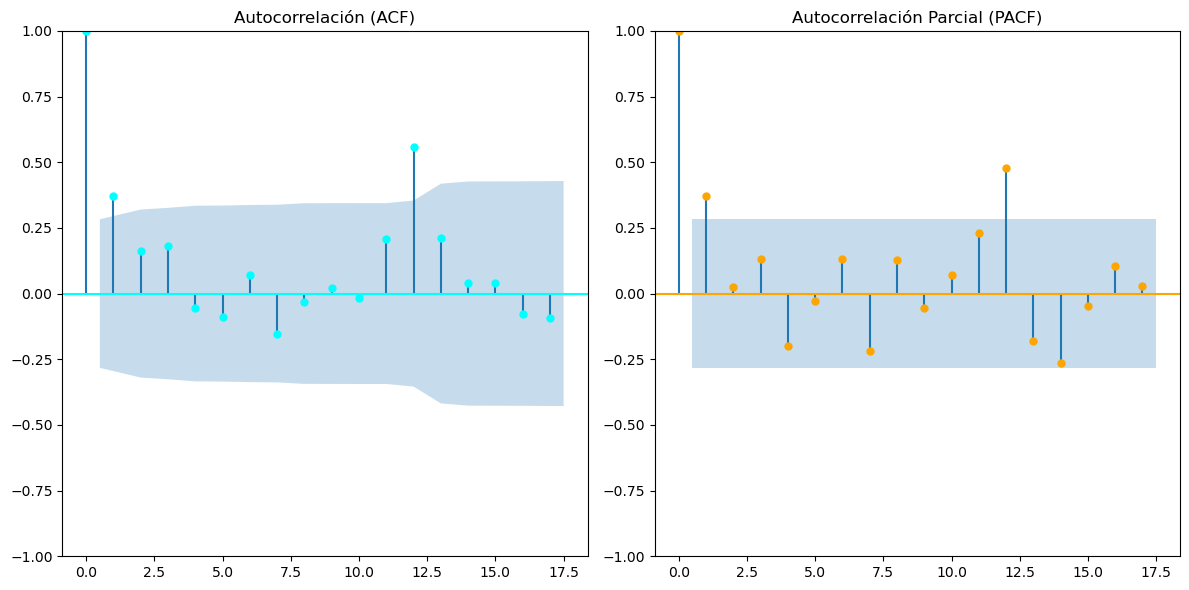

In [104]:
# Paso 3: Identificación de parámetros ARIMA

# Test de Dickey-Fuller para verificar si la serie es estacionaria
adf_test = adfuller(data['Sales'])

# Imprimir el p-value
print("Resultados del Test de Dickey-Fuller:\n")
print(f"- p-value: {adf_test[1]}")  # Nivel de significancia para rechazar la hipótesis nula

# Determinar el valor de d (diferenciación) según el resultado del test ADF
if adf_test[1] > 0.05:  # Si el p-value > 0.05, la serie no es estacionaria
    print("\n\n**La serie no es estacionaria, se aplicará diferenciación.**")
    data_diff = data['Sales'].diff().dropna()  # Realizar la primera diferenciación
    d = 1  # Valor de diferenciación es 1
else:  # Si el p-value <= 0.05, la serie es estacionaria
    print("\n\n**La serie es estacionaria.**")
    data_diff = data['Sales']  # No se necesita diferenciación
    d = 0  # Valor de diferenciación es 0

# Mostrar el valor de d calculado
print(f"\n*El valor estimado de d es: {d}\n")

# Graficar las funciones de autocorrelación (ACF) y autocorrelación parcial (PACF)
plt.figure(figsize=(12, 6))

# Gráfico de autocorrelación (ACF)
plt.subplot(1, 2, 1)
plot_acf(data_diff, ax=plt.gca(), color='cyan')  # Muestra la correlación entre un valor y sus rezagos
plt.title('Autocorrelación (ACF)')

# Gráfico de autocorrelación parcial (PACF)
plt.subplot(1, 2, 2)
plot_pacf(data_diff, ax=plt.gca(), method='ywm', color='orange')  # Muestra la correlación entre un valor y sus rezagos excluyendo otros rezagos
plt.title('Autocorrelación Parcial (PACF)')

# Ajustar el diseño de la figura
plt.tight_layout()
plt.show()


**<span style="color:olive">Descripción de los Gráficos ACF Y PACF</span>**

Los gráficos generados corresponden a las funciones de **autocorrelación (ACF)** y **autocorrelación parcial (PACF)**, los cuales son herramientas clave para identificar los parámetros p y q en un modelo ARIMA.

**Gráfico de Autocorrelación (ACF):**

- Eje X: Representa los lags (t−1,t−2,t−3,…).
- Eje Y: Representa la correlación entre el valor actual (Yt) y los valores en esos rezagos (Y t−k).

- **Interpretación:** Muestra la relación entre un valor y sus lags. Se utiliza para determinar el parámetro q, que indica el orden del componente de media móvil (MA) del modelo ARIMA. Lags significativos, que son los valores que sobresalen de las bandas de confianza, indican cuántos términos de media móvil  deben incluirse en el modelo.

**Gráfico de Autocorrelación Parcial (PACF):**

- Eje X: Representa los lags (t−1,t−2,t−3,…).
- Eje Y: Representa la correlación parcial entre el valor actual (Yt) y los valores en esos rezagos (Y t−k), excluyendo la influencia de lags intermedios.

- **Interpretación:** Muestra la relación directa entre *Yt* y *Y t−k*. Se utiliza para determinar el parámetro p, que indica el orden del componente autorregresivo (AR) del modelo ARIMA. Lags significativos indican cuántos términos autorregresivos deben incluirse en el modelo.


**Observaciones de los Gráficos:**

- En el **gráfico de ACF**, el primer lag (lag 1) tiene una correlación significativa, sobrepasa las bandas de confianza, lo que sugiere que **q=1**.
- En el **gráfico de PACF**, el primer lag (lag 1) también muestra una correlación significativa, lo que sugiere que **p=1**.

- Para lags mayores, las correlaciones caen dentro de las bandas de confianza, lo que indica que no se requieren términos adicionales para p o q.

**Conclusión:** Estos gráficos ayudan a determinar los valores iniciales de los parámetros del modelo ARIMA:

- **p=1:** Por el gráfico de PACF.
- **q=1:** Por el gráfico de ACF.

**NOTA**: eL valor *d* ya fue determinado previamente con el test de Dickey-Fuller.

## <span style="color:orange">Modelado con ARIMA</span>

**Objetivo del Código:** El objetivo de este código es entrenar un modelo ARIMA para realizar predicciones basadas en la serie de tiempo de ventas. Además, se compara un modelo ARIMA manualmente configurado con un modelo ajustado automáticamente usando *auto_arima*.

**División de Datos en Entrenamiento y Prueba**

- Se divide el conjunto de datos en dos partes, esta división permite medir la capacidad del modelo para generalizar y predecir datos nuevos.
    - **Entrenamiento (80%):** Utilizado para ajustar el modelo.
    - **Prueba (20%):** Utilizado para evaluar el modelo con datos no vistos.


1. **Modelo ARIMA Manual**

- Configura un modelo ARIMA utilizando los parámetros:
    - **p=1:** Número de términos autorregresivos (AR).
    - **d=0:** Diferenciación (determinada previamente como estacionaria).
    - **q=1:** Número de términos de media móvil (MA).

- Ajusta el modelo a los datos de entrenamiento, ya que esto permite definir un modelo manual basado en el análisis previo de ACF, PACF y el test de Dickey-Fuller.

2. **Modelo auto_arima**

- Ajusta automáticamente los parámetros p, d, y q para encontrar el mejor modelo.
- Evita la necesidad de interpretar manualmente los gráficos ACF y PACF.
- Lo importante es que **auto_arima** automatiza el proceso de selección de parámetros y encuentra la mejor combinación basada en los datos de entrenamiento.

3. **Predicciones**

- **forecast_arima:** Realiza predicciones utilizando el modelo ARIMA manual.
- **forecast_auto_arima:** Realiza predicciones utilizando el modelo ajustado automáticamente con auto_arima.
- Proporciona dos conjuntos de predicciones, lo que permite comparar el rendimiento de ambos enfoques (manual vs automático).


Estas predicciones pueden evaluarse posteriormente utilizando métricas como el error cuadrático medio (MSE) para determinar qué enfoque se ajusta mejor a los datos de prueba.

In [79]:
# Paso 4: Modelado con ARIMA

# Dividir los datos en conjuntos de entrenamiento y prueba
# Usamos el 80% de los datos para entrenamiento y el 20% restante para prueba
train_size = int(len(data) * 0.8)  # Determinar el tamaño del conjunto de entrenamiento
train, test = data[:train_size], data[train_size:]  # Dividir los datos

# Configurar y entrenar un modelo ARIMA manualmente
# Los valores de p, d, q se basan en el análisis previo de ACF, PACF y el test de Dickey-Fuller
p, d, q = 1, 0, 1  # Valores iniciales para ARIMA (AR, diferenciación, MA)
model = ARIMA(train, order=(p, d, q))  # Crear el modelo ARIMA con los parámetros
model_fit = model.fit()  # Ajustar el modelo a los datos de entrenamiento

# Mostrar los resultados del modelo ARIMA manual
print("Resultados del modelo ARIMA manual:\n")
print(model_fit.summary())


Resultados del modelo ARIMA manual:

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   38
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -433.422
Date:                Sat, 14 Dec 2024   AIC                            874.844
Time:                        22:17:45   BIC                            881.395
Sample:                    01-01-2015   HQIC                           877.175
                         - 02-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.218e+04   4314.939      9.776      0.000    3.37e+04    5.06e+04
ar.L1         -0.2080      0.582     -0.357      0.721      -1.348       0.932
ma.L1          

C:\Users\atapi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\atapi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\atapi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [80]:
# Probar auto_arima para encontrar los mejores parámetros automáticamente
# auto_arima ajusta automáticamente los valores de p, d y q basándose en los datos
arima_auto = auto_arima(
    train['Sales'],  # Serie de tiempo de entrenamiento
    seasonal=False,  # Indica que no hay componente estacional
    trace=True,  # Mostrar el progreso del ajuste
    error_action='ignore',  # Ignorar errores durante el ajuste
    suppress_warnings=True  # Suprimir advertencias
)
print("Modelo auto_arima:")
print(arima_auto.summary())  # Resumen del modelo auto_arima con los mejores parámetros encontrados


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=928.679, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=886.339, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=913.500, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=884.930, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=883.514, Time=0.05 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=885.491, Time=0.03 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=882.460, Time=0.11 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=880.567, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=879.994, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=881.264, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=912.065, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=875.162, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=872.991, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=873.210, 

#### <span style="color:purple">Descripción del los resultados</span>

**<span style="color:olive">Resultados del modelo ARIMA Manual</span>**

**Análisis de Parámetros**

1. **Constante (Intercepto):**
   - La constante es significativa (P = 0.000), lo que indica que el modelo capta una tendencia base en las ventas mensuales.
   - Este término es importante cuando no se aplican diferenciaciones (d = 0).

2. **Término AR (AR.L1, (p = 1)):**
   - Representa la relación entre el valor actual y su lag inmediato (Y_t) y (Y_{t-1}).
   - No es significativo (P = 0.721), lo que sugiere que el componente autorregresivo no contribuye sustancialmente al modelo.

3. **Término MA (MA.L1, (q = 1):**
   - Representa la relación entre el valor actual y el error del lag inmediato.
   - No es significativo (P = 0.368), lo que indica que este término tampoco tiene un impacto claro en el modelo.

4. **Sigma2 (Varianza del Error):**
   - Representa la varianza del ruido/residuo en el modelo.
   - Una varianza alta puede indicar que el modelo no está capturando adecuadamente toda la información de la serie.

**Métricas de Evaluación del Modelo**

- **Log Likelihood (-433.422):** Indica qué tan bien se ajusta el modelo a los datos (valores más altos son mejores).
- **AIC (874.844):** Penaliza la complejidad del modelo (valores más bajos son mejores).
- **BIC (881.395):** Similar al AIC, pero con una penalización mayor para modelos complejos.
- **HQIC (877.175):** Criterio de información alternativo, usado menos frecuentemente.      

- El *AIC* y *BIC* se utilizan para comparar este modelo con otros. Un menor valor sugiere un mejor modelo.


**Pruebas de Diagnóstico**

-  **Ljung-Box (Q) - (P = 0.97):** Los residuos no presentan autocorrelación significativa (buen resultado).
-  **Jarque-Bera (JB) - (P = 0.15):** Los residuos son aproximadamente normales (buen resultado).
-  **Heteroscedasticidad (H) - (P = 0.69):** La varianza de los errores es constante (buen resultado).

- Las pruebas indican que los residuos del modelo no presentan problemas de autocorrelación.

**Advertencias**

1. **Covariance Matrix Warning:**  
   - Indica que la matriz de covarianza es cercana a ser singular. Esto puede afectar la precisión de los errores estándar y las pruebas de significancia.

2. **Frequency Warning:**  
   - La frecuencia de los datos fue inferida automáticamente. Esto puede no ser un problema si los datos están correctamente ordenados por fecha.

**Conclusión**
- El modelo **ARIMA(1, 0, 1)** ajusta la serie, pero los términos AR (p=1) y MA (q=1) no son estadísticamente significativos.
- Las métricas de diagnóstico (Ljung-Box, Jarque-Bera, etc.) sugieren que los residuos están bien comportados.
- Se puede probar modelos como ARIMA(0, 0, 1) o ARIMA(1, 0, 0) para evaluar otros posibles resultados.

---
---

**<span style="color:olive">Resultados del modelo Auto ARIMA</span>**

**Modelo Seleccionado**

- El modelo seleccionado automáticamente por **auto_arima** es **ARIMA(0, 0, 1)** con un intercepto. Esto indica:
    - **p = 0**: No se incluyen términos autorregresivos.
    - **d = 0**: No se aplica diferenciación, ya que la serie es estacionaria.
    - **q = 1**: Se incluye un término de media móvil de primer orden.

- **Búsqueda de Modelos:** *auto_arima+ realiza una búsqueda iterativa sobre múltiples combinaciones de los parámetros (p), (d), y (q), evaluando el **criterio de información Akaike (AIC)** en cada paso. El modelo con el menor valor de AIC se selecciona como el mejor.

**Resultados de la Búsqueda - AIC más bajo:** 872.991 para el modelo ARIMA(0, 0, 1).


**Análisis de Parámetros**
1. **Intercepto:** Es altamente significativo (P = 0.000), indicando que el modelo incluye un valor base consistente para las ventas mensuales.

2. **Término MA (MA.L1,(q=1):**
   - Representa la relación entre el error actual y el error del lag inmediato.
   - No es completamente significativo (P = 0.068), lo que indica que podría no ser un componente crítico del modelo.

3. **Sigma2 (Varianza del Error):** Representa la varianza del ruido/residuo en el modelo.

**Métricas de Evaluación del Modelo**

- **Log Likelihood (-433.495):** Indica qué tan bien se ajusta el modelo a los datos (valores más altos son mejores).
- **AIC (872.991):** Penaliza la complejidad del modelo (valores más bajos son mejores).                                           
- **BIC (877.993):** Similar al AIC, pero con una penalización mayor para modelos complejos.                                      
- **HQIC (874.739):** Criterio de información alternativo, usado menos frecuentemente.    

- El *AIC* es el criterio principal utilizado por *auto_arima* para seleccionar el mejor modelo.

**Pruebas de Diagnóstico**

- **Ljung-Box (Q) - (P = 0.94):** Los residuos no presentan autocorrelación significativa (buen resultado).                      
- **Jarque-Bera (JB) - (P = 0.18):** Los residuos son aproximadamente normales (buen resultado).                                    
- **Heteroscedasticidad (H) - (P = 0.66):** La varianza de los errores es constante (buen resultado).                                      

- Estas pruebas indican que los residuos del modelo están bien comportados, sin problemas significativos de autocorrelación, normalidad o heteroscedasticidad.

**Conclusión**
- **Modelo Seleccionado:** ARIMA(0, 0, 1) con intercepto.
- **Fortalezas del Modelo:**
  - El AIC es el más bajo entre las combinaciones probadas, indicando un buen ajuste con menor complejidad.
  - Los residuos cumplen con las pruebas de diagnóstico.

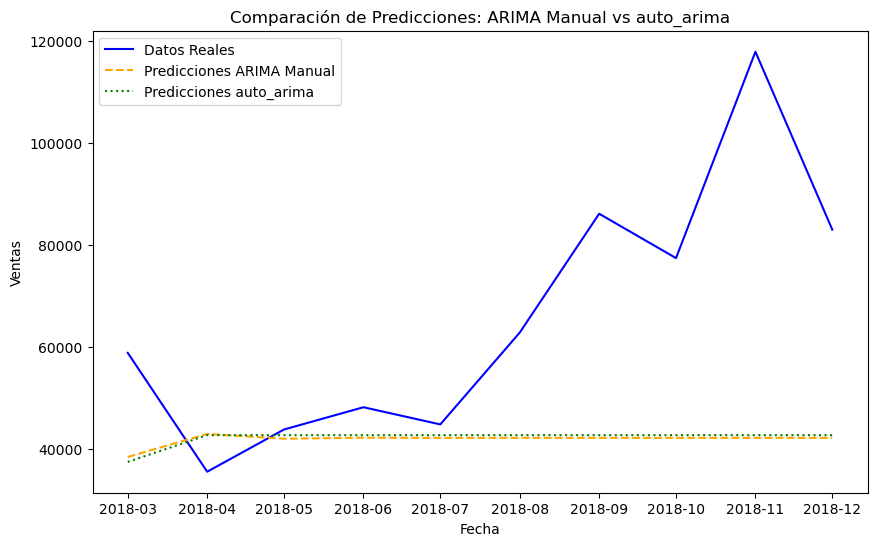

In [82]:
# Realizar predicciones con el modelo ARIMA manual
forecast_arima = model_fit.forecast(steps=len(test))  # Predicciones para el tamaño del conjunto de prueba

# Realizar predicciones con el modelo auto_arima
forecast_auto_arima = arima_auto.predict(n_periods=len(test))  # Predicciones automáticas para el conjunto de prueba

# Graficar las predicciones vs los datos reales
plt.figure(figsize=(10, 6))

# Datos reales
plt.plot(test.index, test['Sales'], label='Datos Reales', color='blue')

# Predicciones ARIMA manual
plt.plot(test.index, forecast_arima, label='Predicciones ARIMA Manual', linestyle='--', color='orange')

# Predicciones auto_arima
plt.plot(test.index, forecast_auto_arima, label='Predicciones auto_arima', linestyle=':', color='green')

# Configuración del gráfico
plt.title('Comparación de Predicciones: ARIMA Manual vs auto_arima')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.show()


#### <span style="color:purple">Comparación de Predicciones: ARIMA Manual vs auto_arima</span>

**Descripción del Gráfico**
Este gráfico compara las predicciones realizadas por dos modelos ARIMA:
1. **ARIMA Manual:** Modelo configurado manualmente con parámetros específicos **(p=1, d=0, q=1)**.
2. **auto_arima:** Modelo ajustado automáticamente por *auto_arima* con parámetros óptimos **(p=0, d=0, q=1)**.

Ambos modelos son evaluados con los datos reales de ventas en el conjunto de prueba.


**Elementos del Gráfico**
1. **Línea Azul (Datos Reales):**
   - Representa las ventas reales en el período de prueba.
   - Muestra la evolución real de las ventas a lo largo del tiempo.

2. **Línea Naranja (Predicciones ARIMA Manual):**
   - Representa las predicciones realizadas por el modelo configurado manualmente.
   - Aparece como una línea discontinua.

3. **Línea Verde (Predicciones auto_arima):**
   - Representa las predicciones realizadas por el modelo ajustado automáticamente.
   - Aparece como una línea punteada.


**Observaciones del Gráfico**
1. **Datos Reales:**
   - Las ventas reales presentan una gran variabilidad, con picos y caídas significativas, especialmente en el tramo final del período de prueba.

2. **Predicciones ARIMA Manual:**
   - El modelo manual genera predicciones constantes y no logra capturar la variabilidad observada en los datos reales.
   - Esto sugiere que el modelo es demasiado simple para ajustarse correctamente a la serie de tiempo.

3. **Predicciones auto_arima:**
   - Similar al modelo manual, el modelo ajustado automáticamente genera predicciones constantes.
   - Aunque el modelo fue optimizado para los datos de entrenamiento, no logra reflejar la variabilidad en los datos reales del período de prueba.

---

 **Conclusión**
 
 Ambos modelos (manual y automático) fallan en capturar la complejidad de los datos reales:
   - Generan predicciones constantes y subestiman las fluctuaciones observadas en las ventas.
   - Esto indica que los modelos ajustados no son adecuados para la serie de tiempo analizada.

## <span style="color:orange">Evaluación del Modelo: ARIMA Manual vs auto_arima</span>

El objetivo es evaluar el rendimiento de ambos modelos utilizando métricas de error y visualizar sus predicciones en comparación con los datos reales.

**Paso a Paso del Código**

1. **Importación de Métricas de Evaluación:** Se utiliza **mean_squared_error (MSE)** y **mean_absolute_error (MAE)** del módulo *sklearn.metrics*.

2. **Cálculo del MSE y MAE:**
   - **MSE:** Penaliza los errores más grandes al elevarlos al cuadrado. Es útil para identificar modelos con errores extremos.
   - **MAE:** Promedia los errores absolutos, ofreciendo una medida más intuitiva del error promedio sin penalizar en exceso los grandes errores.
   - Se calculan ambas métricas para:
     - El modelo ARIMA manual (*forecast_arima*).
     - El modelo auto_arima (*forecast_auto_arima*).

3. **Visualización de Predicciones:**
   - Se grafica:
     - **Datos Reales:** Ventas reales del conjunto de prueba.
     - **Predicciones ARIMA Manual:** Curva discontinua en color naranja.
     - **Predicciones auto_arima:** Curva punteada en color verde.
   - Se agregan etiquetas y leyendas para identificar cada conjunto de datos.

---

**Interpretación del Gráfico**

1. **Línea Azul (Datos Reales):**
   - Representa las ventas reales en el período de prueba.
   - Es la referencia para evaluar la precisión de las predicciones.

2. **Línea Naranja (Predicciones ARIMA Manual):**
   - Representa las predicciones generadas por el modelo configurado manualmente.
   - Una mayor cercanía a los datos reales indica un mejor ajuste.

3. **Línea Verde (Predicciones auto_arima):**
   - Representa las predicciones del modelo ajustado automáticamente.
   - Permite comparar directamente el rendimiento frente al modelo manual.


MSE del modelo ARIMA manual: 1153031860.244976

MAE del modelo ARIMA manual: 25478.756168108812

MSE del modelo auto_arima: 1132640441.945601

MAE del modelo auto_arima: 25108.77670507918


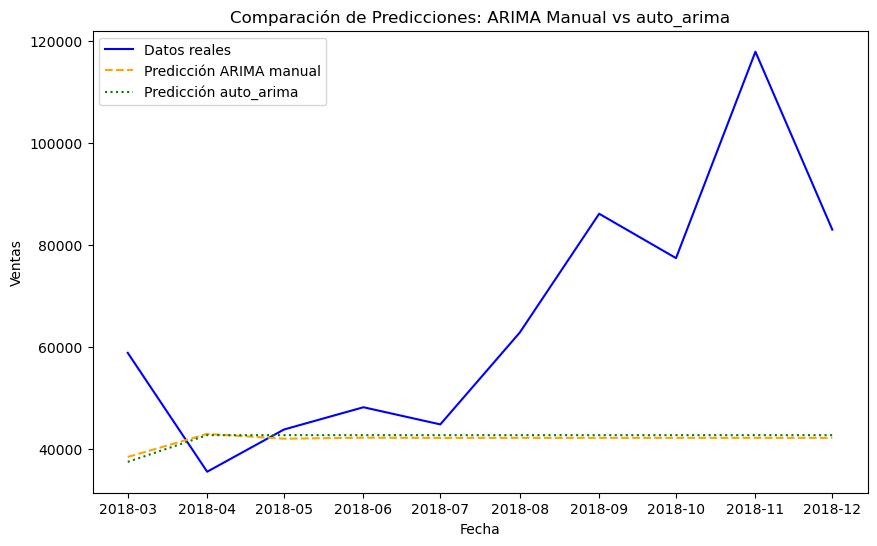

In [85]:
# **Cálculo del MSE y MAE para el modelo ARIMA manual**
# MSE: Penaliza los errores más grandes al elevarlos al cuadrado
mse_arima = mean_squared_error(test['Sales'], forecast_arima)
# MAE: Promedia los errores absolutos, mostrando el error promedio sin penalizar en exceso los grandes errores
mae_arima = mean_absolute_error(test['Sales'], forecast_arima)

#_______________________________________________________________________________________________________________________________________________

# **Cálculo del MSE y MAE para el modelo auto_arima**
mse_auto_arima = mean_squared_error(test['Sales'], forecast_auto_arima)
mae_auto_arima = mean_absolute_error(test['Sales'], forecast_auto_arima)

#_______________________________________________________________________________________________________________________________________________


# **Imprimir las métricas calculadas**
# Esto ayuda a comparar el rendimiento de los modelos manual y automático en términos de precisión
print(f"MSE del modelo ARIMA manual: {mse_arima}")
print(f"\nMAE del modelo ARIMA manual: {mae_arima}")
print(f"\nMSE del modelo auto_arima: {mse_auto_arima}")
print(f"\nMAE del modelo auto_arima: {mae_auto_arima}")

# **Visualización de las predicciones**
plt.figure(figsize=(10, 6))

# Graficar los datos reales (ventas del conjunto de prueba)
plt.plot(test['Sales'], label='Datos reales', color='blue')

# Graficar las predicciones del modelo ARIMA manual
plt.plot(test.index, forecast_arima, label='Predicción ARIMA manual', linestyle='--', color='orange')

# Graficar las predicciones del modelo auto_arima
plt.plot(test.index, forecast_auto_arima, label='Predicción auto_arima', linestyle=':', color='green')

# **Personalización del gráfico**
# Agregar leyenda para identificar cada curva
plt.legend()
# Título del gráfico para describir qué se está visualizando
plt.title('Comparación de Predicciones: ARIMA Manual vs auto_arima')
# Etiquetas de los ejes
plt.xlabel('Fecha')
plt.ylabel('Ventas')
# Mostrar el gráfico
plt.show()


#### <span style="color:purple">Análisis de Resultados: ARIMA Manual vs auto_arima</span>

El código calcula las métricas de error (MSE y MAE) para dos modelos ARIMA (manual y ajustado automáticamente) y compara sus predicciones contra los datos reales del conjunto de prueba. Los resultados son los siguientes:

1. **Error Cuadrático Medio (MSE):**
   - El modelo **auto_arima** tiene un MSE ligeramente menor (1132640441.95) comparado con el modelo **ARIMA manual** (1155031860.24).
   - Esto indica que las predicciones del modelo auto_arima están un poco más cerca de los datos reales en promedio, penalizando más los grandes errores.

2. **Error Absoluto Medio (MAE):**
   - El MAE del modelo **auto_arima** (25108.78) también es menor que el del modelo **ARIMA manual** (25478.76).
   - Esto refuerza la idea de que auto_arima ofrece predicciones marginalmente mejores, ya que tiene un error promedio absoluto más bajo.


**Gráfico: Comparación de Predicciones**

1. **Línea Azul (Datos Reales):** Muestra fluctuaciones significativas, con un gran pico hacia finales del período.

2. **Línea Naranja (ARIMA Manual):** No capta la variabilidad ni los picos observados en los datos reales, lo que sugiere que el modelo manual es demasiado simple para esta serie de tiempo.

3. **Línea Verde (auto_arima):** Aunque los valores están más ajustados a los datos reales en promedio, sigue sin capturar los picos o fluctuaciones.

---

**Observaciones**

1. **Similitud de los Modelos:**
   - Ambos modelos producen predicciones constantes, lo que indica que ninguno está capturando la complejidad de la serie de tiempo.
   - Esto puede deberse a la ausencia de términos estacionales o a la inadecuación de los parámetros (p, d, q) seleccionados.

2. **Diferencia en Rendimiento:**
   - Aunque el modelo **auto_arima** tiene un rendimiento ligeramente mejor que el manual (menor MSE y MAE), la diferencia es mínima.
   - Esto sugiere que el ajuste automático no logró una mejora significativa debido a limitaciones inherentes en los datos o el enfoque ARIMA utilizado.

3. **Datos Reales vs Predicciones:** Los datos reales muestran un patrón más dinámico, con picos y caídas significativas, que ninguno de los modelos logra replicar.

---

**Conclusión**
- **auto_arima** tiene un rendimiento mínimo mejor que el modelo manual, pero ambos presentan limitaciones importantes al no capturar la variabilidad de los datos reales.
- **Problemas Identificados:**
  - Predicciones constantes sugieren que los modelos son demasiado simples para esta serie de tiempo.
  - Los picos y las fluctuaciones de los datos reales no se reflejan en las predicciones.


---
---

**De forma anexa se adjunta el siguiente gráfico para comprar los Dsatos vs las Predicciones** 

- **Comparación: Datos vs Predicciones**

En este gráfico se muestran los resultados del análisis de series de tiempo utilizando el modelo ARIMA. El propósito del gráfico es evaluar el rendimiento del modelo al predecir las ventas futuras, comparando las predicciones con los datos históricos.

- **Datos de Entrenamiento (línea azul):** Representa las ventas históricas utilizadas para entrenar el modelo ARIMA.
- **Datos de Prueba (línea naranja):** Incluye los valores reales de ventas que no se usaron en el entrenamiento, utilizados para validar el modelo.
- **Predicciones (línea verde):** Muestra las proyecciones realizadas por el modelo ARIMA para el período de prueba.


- **Interpretación del Gráfico: Comparación entre Datos y Predicciones**

1. **Patrones Capturados:** El modelo ARIMA parece haber capturado correctamente algunos patrones básicos de tendencia en las ventas.

2. **Desempeño en la Prueba:**
   - Aunque las predicciones siguen el comportamiento general, existen discrepancias notables, especialmente hacia el final del periodo de prueba.
   - Esto sugiere que el modelo subestima las ventas en períodos de crecimiento.

3. **Conclusión:**
   - El modelo ofrece una base inicial, pero requiere ajustes adicionales para mejorar su precisión.
   - Se podrían probar técnicas como:
     - Optimización de parámetros (p, d, q).
     - Consideración explícita de la estacionalidad (por ejemplo, con SARIMA).
     - Incrementar los datos de entrenamiento para mejorar la capacidad predictiva.


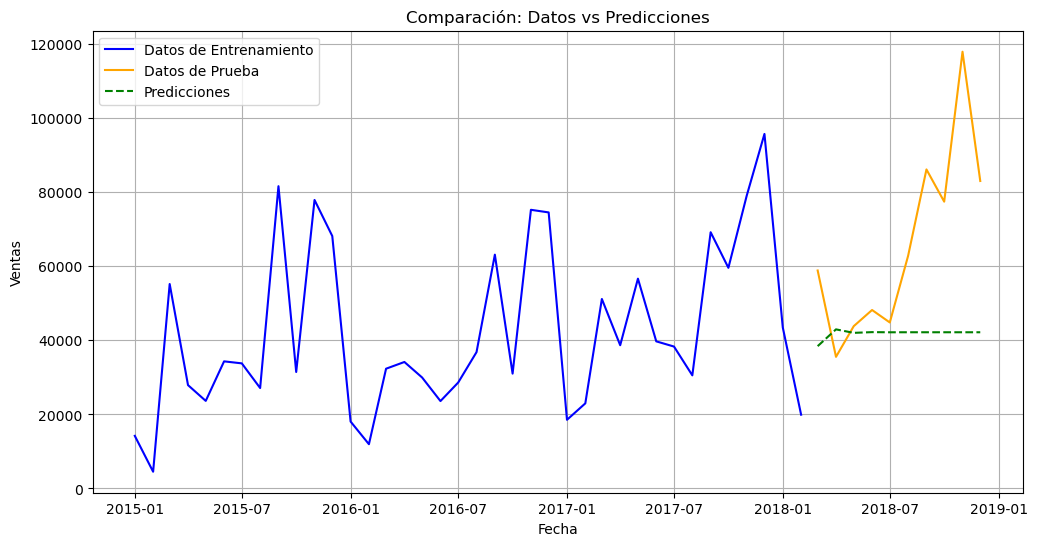

In [88]:
plt.figure(figsize=(12, 6))
plt.plot(train, label='Datos de Entrenamiento', color='blue')
plt.plot(test, label='Datos de Prueba', color='orange')
plt.plot(forecast_arima, label='Predicciones', color='green', linestyle='--')
plt.title('Comparación: Datos vs Predicciones')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend(loc='best')
plt.grid(True)
plt.show()
